#**Assignment 3 - ANN (Approximate Nearest Neighbor)**

**Goal:** Implement the following ANN algorithm on Airbnb New York dataset

*   Exhaustive Search
*   Product Quantization
*   LSH (Locality Sensitive Hashing)
*   Hierarchical Navigable Small World Graphs
*   Trees and Graphs

**Dataset:** 

Dataset is downloaded from kaggle which is of NewYork Airbnb: https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

**Data Cleaning:** process of fixing or removing incorrect, corrupted, incorrectly formatted, duplicate, or incomplete data within a dataset. If data is incorrect, outcomes and algorithms are unreliable.

**Data Preprocessing:** manipulation or dropping of data before it is used in order to ensure or enhance performance

In [134]:
#Importing all the required libraries

import warnings
warnings.filterwarnings('ignore')

#General Use
import pandas as pd
import numpy as np
from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import io
import requests
from google.colab import drive

#Clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

#3D Visualization
import plotly as py
import plotly.graph_objs as go

%matplotlib inline

In [135]:
drive.mount('/content/drive/')
df = pd.read_csv('/content/drive/MyDrive/DataMining/Assignment1/AB_NYC_2019.csv')
df.head(10)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129
6,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,45,49,2017-10-05,0.40,1,0
7,5178,Large Furnished Room Near B'way,8967,Shunichi,Manhattan,Hell's Kitchen,40.76489,-73.98493,Private room,79,2,430,2019-06-24,3.47,1,220
8,5203,Cozy Clean Guest Room - Family Apt,7490,MaryEllen,Manhattan,Upper West Side,40.80178,-73.96723,Private room,79,2,118,2017-07-21,0.99,1,0
9,5238,Cute & Cozy Lower East Side 1 bdrm,7549,Ben,Manhattan,Chinatown,40.71344,-73.99037,Entire home/apt,150,1,160,2019-06-09,1.33,4,188


In [136]:
print(df.shape)

(48895, 16)


### Data - **Preprocessing**

In [137]:
df = df.drop(df[(df['name']).str.len() < 5].index)

In [138]:
#To understand the number of columns and rows we need to work with
print(df.shape)

(48826, 16)


In [139]:
# Dropping the rows where the host name of the person listing the AirBnb property is less than 3 characters, 
#on closer inspection found that these values were invalid. Hence getting rid of those records.

df = df.drop(df[(df['host_name']).str.len() < 3].index)

In [140]:
# number of columns and rows reduced
print(df.shape)

(48095, 16)


In [141]:
#Extracting the data type information of all the columns to work appropriately 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48095 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48095 non-null  int64  
 1   name                            48079 non-null  object 
 2   host_id                         48095 non-null  int64  
 3   host_name                       48074 non-null  object 
 4   neighbourhood_group             48095 non-null  object 
 5   neighbourhood                   48095 non-null  object 
 6   latitude                        48095 non-null  float64
 7   longitude                       48095 non-null  float64
 8   room_type                       48095 non-null  object 
 9   price                           48095 non-null  int64  
 10  minimum_nights                  48095 non-null  int64  
 11  number_of_reviews               48095 non-null  int64  
 12  last_review                     

In [142]:
#Get unique count for each column
df.nunique()

id                                48095
name                              47128
host_id                           36828
host_name                         11213
neighbourhood_group                   5
neighbourhood                       221
latitude                          18932
longitude                         14609
room_type                             3
price                               671
minimum_nights                      109
number_of_reviews                   390
last_review                        1757
reviews_per_month                   935
calculated_host_listings_count       47
availability_365                    366
dtype: int64

In [143]:
#Calculating statistical data
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.809500e+04,4.809500e+04,48095.000000,48095.000000,48095.000000,48095.000000,48095.000000,38211.000000,48095.000000,48095.000000
mean,1.901470e+07,6.755719e+07,40.728829,-73.952200,152.499595,7.062231,23.174696,1.371417,7.233829,112.672190
std,1.097591e+07,7.855660e+07,0.054518,0.046074,240.675443,20.644556,44.250934,1.681044,33.217194,131.656201
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.473863e+06,7.831209e+06,40.689950,-73.983030,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967332e+07,3.077553e+07,40.722890,-73.955650,106.000000,3.000000,5.000000,0.710000,1.000000,44.000000
75%,2.914741e+07,1.074344e+08,40.763070,-73.936205,175.000000,5.000000,23.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.911690,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


In [144]:
#Dropping columns that do not contribute in training the model
df_extract = df.drop(['host_name', 'neighbourhood','minimum_nights', 'last_review', "reviews_per_month"], axis = 'columns')
df_extract.head()

,id,name,host_id,neighbourhood_group,latitude,longitude,room_type,price,number_of_reviews,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,Brooklyn,40.64749,-73.97237,Private room,149,9,6,365
1,2595,Skylit Midtown Castle,2845,Manhattan,40.75362,-73.98377,Entire home/apt,225,45,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,40.80902,-73.94190,Private room,150,0,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,Brooklyn,40.68514,-73.95976,Entire home/apt,89,270,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Manhattan,40.79851,-73.94399,Entire home/apt,80,9,1,0


In [145]:
#Renaming the columns to have more apt and meaningful names
df_extract.rename({"neighbourhood_group": "NYC-Boroughs", "calculated_host_listings_count": "num_of_host_listings"})
df_extract.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48095 entries, 0 to 48894
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48095 non-null  int64  
 1   name                            48079 non-null  object 
 2   host_id                         48095 non-null  int64  
 3   neighbourhood_group             48095 non-null  object 
 4   latitude                        48095 non-null  float64
 5   longitude                       48095 non-null  float64
 6   room_type                       48095 non-null  object 
 7   price                           48095 non-null  int64  
 8   number_of_reviews               48095 non-null  int64  
 9   calculated_host_listings_count  48095 non-null  int64  
 10  availability_365                48095 non-null  int64  
dtypes: float64(2), int64(6), object(3)
memory usage: 5.7+ MB


In [146]:
#Dropping the rows where the availablity for that property is 0.
df_extract = df_extract.drop(df_extract[(df_extract['availability_365']) == 0].index)

In [147]:
#Number of columns reduced to [30802 rows x 10 columns]
df_extract.count

<bound method DataFrame.count of              id  ... availability_365
0          2539  ...              365
1          2595  ...              355
2          3647  ...              365
3          3831  ...              194
5          5099  ...              129
...         ...  ...              ...
48890  36484665  ...                9
48891  36485057  ...               36
48892  36485431  ...               27
48893  36485609  ...                2
48894  36487245  ...               23

[30802 rows x 11 columns]>

In [148]:
# df['NYC-Boroughs'] = df['NYC-Boroughs'].astype('str')
# df['room_type'] = df['room_type'].astype('str')

#Removing propeties where the price of a "Private room" room type is less than 30, as it inaccurate value for an avg price in NYC listing

df_price_check = df_extract.drop( df_extract[ ( df_extract['price'] < 30 ) & ( df_extract['room_type'] == 'Private room') ].index )

In [149]:
df_price_check.count

<bound method DataFrame.count of              id  ... availability_365
0          2539  ...              365
1          2595  ...              355
2          3647  ...              365
3          3831  ...              194
5          5099  ...              129
...         ...  ...              ...
48890  36484665  ...                9
48891  36485057  ...               36
48892  36485431  ...               27
48893  36485609  ...                2
48894  36487245  ...               23

[30691 rows x 11 columns]>

In [150]:
#Removing propeties where the price of a "Entire home/apt" room type is less than 50, as it inaccurate value for an avg price in NYC listing

df_price_check = df_price_check.drop( df_price_check[ ( df_price_check['price'] < 50 ) & ( df_price_check['room_type'] == 'Entire home/apt') ].index )

In [151]:
#Number of columns reduced to [30617 rows x 10 columns]
df_price_check.count

<bound method DataFrame.count of              id  ... availability_365
0          2539  ...              365
1          2595  ...              355
2          3647  ...              365
3          3831  ...              194
5          5099  ...              129
...         ...  ...              ...
48890  36484665  ...                9
48891  36485057  ...               36
48892  36485431  ...               27
48893  36485609  ...                2
48894  36487245  ...               23

[30617 rows x 11 columns]>

In [152]:
df_price_check.head()

,id,name,host_id,neighbourhood_group,latitude,longitude,room_type,price,number_of_reviews,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,Brooklyn,40.64749,-73.97237,Private room,149,9,6,365
1,2595,Skylit Midtown Castle,2845,Manhattan,40.75362,-73.98377,Entire home/apt,225,45,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Manhattan,40.80902,-73.94190,Private room,150,0,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,Brooklyn,40.68514,-73.95976,Entire home/apt,89,270,1,194
5,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Manhattan,40.74767,-73.97500,Entire home/apt,200,74,1,129


#Data Exploration

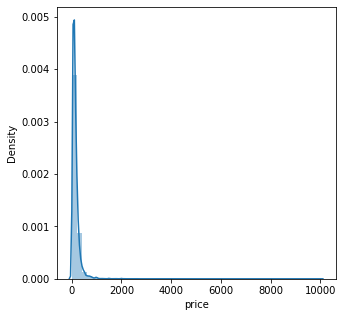

In [153]:
import seaborn as sns
#Distribution of Price

plt.figure(figsize= (5, 5))
sns.distplot(df_price_check['price'])

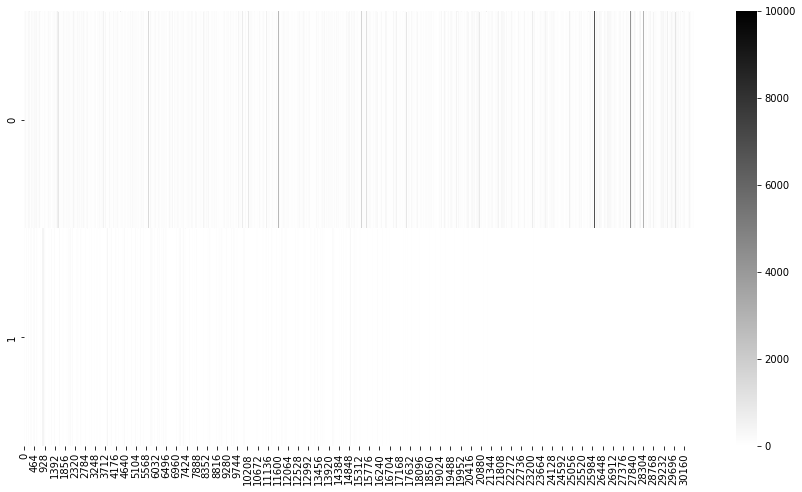

In [154]:
##Average price of a property

plt.figure(figsize=(15, 8))
cross = ((df_price_check['price']) , df_price_check['number_of_reviews'])
sns.heatmap(cross, annot=False, fmt='g', cmap='binary')

In [155]:
df_price_check = df_price_check.rename(columns={'neighbourhood_group' : "NYC_Boroughs"})

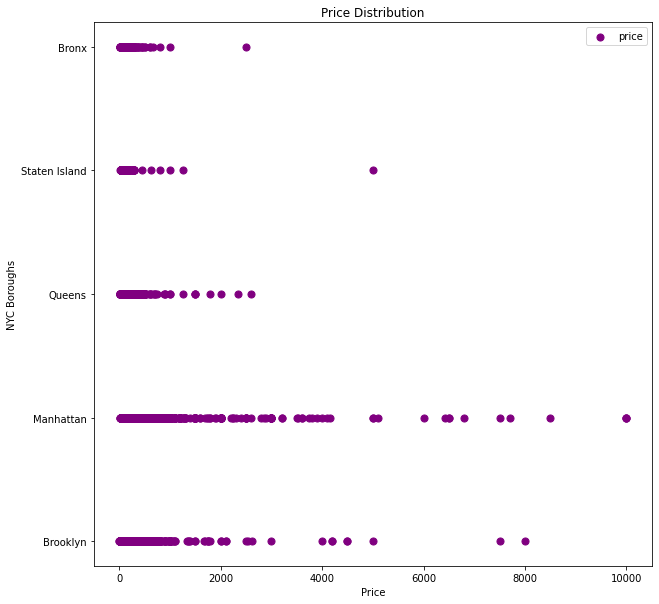

In [156]:
#Plotting a chart to show the price distribution based on the NYC boroughs

def plot_scatter_chart(df_price_check):
    plt.rcParams['figure.figsize'] = (10,10)
    plt.scatter(df_price_check.price,df_price_check.NYC_Boroughs,color='purple',label='price', s=50)
    plt.xlabel("Price")
    plt.ylabel("NYC Boroughs")
    plt.title("Price Distribution")
    plt.legend()
plot_scatter_chart(df_price_check)

##**Applying model training with scikit learn - Linear Regression**

##Training the model with number of reviews and price to predict price of properties on AirBnb listings - popularity

In [157]:
from sklearn import linear_model

regs = linear_model.LinearRegression()
regs.fit(df_price_check[['number_of_reviews']], df_price_check['price'])

LinearRegression()

In [158]:
#Getting the Coefficient
regs.coef_

array([-0.36454031])

In [159]:
#Getting the Intercept
regs.intercept_

174.10931736603683

In [160]:
#Predicting the price of an AirBnb with number of reviews - implying popularity
regs.predict([[4]])

array([172.65115614])

##Training the model with minimum_nights and price to predict price of properties on AirBnb listings - avg price

In [161]:
from sklearn import linear_model

regs = linear_model.LinearRegression()
regs.fit(df[['minimum_nights']], df['price'])

LinearRegression()

In [162]:
#Getting the Coefficient
regs.coef_

array([0.5024967])

In [163]:
#Getting the Intercept
regs.intercept_

148.95084674450146

In [164]:
#Predicting the price of an AirBnb with minimum nights stay - implying avg price
regs.predict([[4]])

array([150.96083356])

#**Exhaustive Search using Faiss**

Exhaustic search using Fiass Library.

Faiss is a library used for making the similarity search more efficient and clustering of dense vectors.

The algorithms can search in sets of vectors of any size.

Exhaustive Search is the only available method for guaranteed retrieval of the exact nearest neighbor is exhaustive search.

**Selected 5000 dataset to perform the Exhaustive Search Algorithm**

In [165]:
airbnb_df = df_price_check['name'].copy()

In [166]:
airbnb_df2 = airbnb_df.head(5000).copy()

In [167]:
df_vec = df_price_check.copy()

###**Performing vectorization on the dataset**

In [168]:
df_vec = df_vec[['latitude', 'longitude', 'price']]

In [169]:
df_vec2 = df_vec.head(5000).copy()

In [170]:
numpy_array = np.array(airbnb_df2)

In [171]:
numpy_array

array(['Clean & quiet apt home by the park', 'Skylit Midtown Castle',
       'THE VILLAGE OF HARLEM....NEW YORK !', ...,
       'Modern Vibrant Large Cozy Bedroom* 正面能量',
       'BRAND NEW 1BD / STEPS CENTRAL PARK!',
       'Share quiet, clean and spacious apt'], dtype=object)

In [172]:
df_vec2

,latitude,longitude,price
0,40.64749,-73.97237,149
1,40.75362,-73.98377,225
2,40.80902,-73.94190,150
3,40.68514,-73.95976,89
5,40.74767,-73.97500,200
...,...,...,...
8016,40.68678,-73.96044,100
8018,40.57770,-73.93988,45
8020,40.82122,-73.92773,56
8022,40.76877,-73.98460,87


In [173]:
df_vec2['latitude'] = df_vec2.latitude.values * 1.05 + 1

In [174]:
df_vec2['longitude'] = df_vec2.longitude.values * 1.05 + 1

In [175]:
df_vec2['price'] = df_vec2.price.values * 1.05 + 1

In [176]:
df_vec2

,latitude,longitude,price
0,43.679865,-76.670989,157.45
1,43.791301,-76.682958,237.25
2,43.849471,-76.638995,158.50
3,43.719397,-76.657748,94.45
5,43.785054,-76.673750,211.00
...,...,...,...
8016,43.721119,-76.658462,106.00
8018,43.606585,-76.636874,48.25
8020,43.862281,-76.624117,59.80
8022,43.807209,-76.683830,92.35


In [177]:
vec = np.array(df_vec2)

In [178]:
vec

array([[ 43.6798645, -76.6709885, 157.45     ],
       [ 43.791301 , -76.6829585, 237.25     ],
       [ 43.849471 , -76.638995 , 158.5      ],
       ...,
       [ 43.862281 , -76.6241165,  59.8      ],
       [ 43.8072085, -76.68383  ,  92.35     ],
       [ 43.666099 , -76.820939 ,  43.       ]])

###**Installing Faiss which is a library that performs the similarity search efficiently and clustering of dense vectors**

In [179]:
!pip install faiss

In [180]:
!apt install libomp-dev
!python -m pip install --upgrade faiss faiss-gpu
import faiss

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (5.0.1-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [181]:
vectors=np.ascontiguousarray(vec)

In [182]:
vectors.flags

  C_CONTIGUOUS : True
  F_CONTIGUOUS : False
  OWNDATA : True
  WRITEABLE : True
  ALIGNED : True
  WRITEBACKIFCOPY : False
  UPDATEIFCOPY : False

In [183]:
vectors = vectors.astype('float32')

**Building the index with airbnb dataset**

In [184]:
import faiss
faiss.MatrixStats(vectors).comments.split("\n")

['analyzing 5000 vectors of size 3',
 'no NaN or Infs in data',
 'all vectors are distinct',
 'range of L2 norms=[92.3385, 8401.46] (0 null vectors)',
 'matrix contains no 0s',
 'no constant dimensions',
 'no dimension has a too large mean',
 'stddevs per dimension are in [0.0414656 251.17]',
 '']

In [185]:
index = faiss.IndexFlatL2(vectors.shape[1])
index.add(vectors)

In [186]:
search_vector = vectors[90:91]
distances, indices = index.search(search_vector, 10)

###**Result: We found that the most similar hotels by passing a hotel name in the function**

The most similar AirBnb Properties to Monkey Retreat Manhattan are:
['Monkey Retreat Manhattan', 'Charming Private Room', 'Gorgeous apt. steps from subway', 'HARLEM, NEW YORK WELCOMES YOU!!', 'Cozy Harlem Experience']

In [187]:
print(f"The most similar hotels to {numpy_array[85]} are:\n")
print([numpy_array[i] for i in indices[0]])

The most similar hotels to Upper Manhattan, New York are:

['Monkey Retreat Manhattan', 'Charming Private Room', 'Gorgeous apt. steps from subway', 'HARLEM, NEW YORK WELCOMES YOU!!', 'Cozy Harlem Experience', 'Cozy  and sunny room in Manhattan', 'Small, Cozy, Clean and Modern private room!', 'Spacious very High ceiling place !', 'Great and private place to stay in Manhattan!', 'Convenience & Chill']


In [188]:
quantizer = faiss.IndexFlatL2(vectors.shape[1])
index = faiss.IndexIVFFlat(quantizer, 
                           vectors.shape[1], 
                           100)               # search_in_x_partitions
index.train(vectors)
index.add(vectors)

In [189]:
search_vector = vectors[90:91]

In [190]:
 distances, indices = index.search(search_vector, 5)

In [191]:
print(f"The most similar hotels to {numpy_array[90]} are:\n")
print([numpy_array[i] for i in indices[0]])

The most similar hotels to Monkey Retreat Manhattan are:

['Monkey Retreat Manhattan', 'Charming Private Room', 'Gorgeous apt. steps from subway', 'HARLEM, NEW YORK WELCOMES YOU!!', 'Cozy Harlem Experience']


#**Product Quantization**

Defining the function that performs the Vector Encoding and returns the most similar hotels to the hotel that are passed into the function.

Quantization-based algorithms are one of the most common strategies when it comes to ANN.

Reduces the dataset size from linear to quantizer by defining a function that encodes the dataset into a compact approximated representation.

In [192]:
quantizer = faiss.IndexFlatL2(vectors.shape[1])
index = faiss.IndexIVFPQ(quantizer, 
                         vectors.shape[1], 
                         100,             # number_of_partition,
                         3,               # search_in_x_partitions, 
                         6)               # subvector_size
index.train(vectors)
index.add(vectors)

In [193]:
search_vector = vectors[90:91]
distances, indices = index.search(search_vector, 10)

###**Result: We found that the result of the vector encoding is similar to the Exhaustive Search algorithm**

The most similar hotels to Monkey Retreat Manhattan are:
['Monkey Retreat Manhattan', 'HARLEM, NEW YORK WELCOMES YOU!!', 'Charming Private Room', 'Gorgeous apt. steps from subway', 'Budget/diamond in heart of Harlem', 'Spacious very High ceiling place !', 'Cozy and sunny room in Manhattan', 'Cozy Harlem Experience', 'Convenience & Chill', 'Small, Cozy, Clean and Modern private room

In [194]:
print(f"The most similar hotels to {numpy_array[90]} are:\n")
print([numpy_array[i] for i in indices[0]])

The most similar hotels to Monkey Retreat Manhattan are:

['Monkey Retreat Manhattan', 'HARLEM, NEW YORK WELCOMES YOU!!', 'Charming Private Room', 'Gorgeous apt. steps from subway', 'Budget/diamond in heart of Harlem', 'Spacious very High ceiling place !', 'Cozy  and sunny room in Manhattan', 'Cozy Harlem Experience', 'Convenience & Chill', 'Small, Cozy, Clean and Modern private room!']


#**LSH (Locality Sensitive Hashing)**

LSH-based algorithms are one of the most common strategies when it comes to ANN.
They construct a hash table as their data structure by mapping points that are nearby into the same bucket. A larger value will give more accurate results, but larger indexes.

In [195]:
class LSHIndex():
  def __init__(self, vectors, labels):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels    
   
  def build(self, num_bits=8):
        self.index = faiss.IndexLSH(self.dimension, num_bits)
        self.index.add(self.vectors)

  def query(self, vectors, k=10):
        distances, indices = self.index.search(vectors, k) 
        # I expect only query on one vector thus the slice
        return [self.labels[i] for i in indices[0]]

In [196]:
index = LSHIndex(vectors,numpy_array)
index.build()

In [198]:
index.query(vectors)

['Modern 1 BR / NYC / EAST VILLAGE',
 'BEST BET IN HARLEM',
 'Country space in the city',
 'THE VILLAGE OF HARLEM....NEW YORK !',
 'Cute & Cozy Lower East Side 1 bdrm',
 'Entire apartment in central Brooklyn neighborhood.',
 'Cozy 1BD on Central Park West in New York City',
 'Greenpoint Place...Has It All! ',
 'Midtown Pied-a-terre',
 'Clean & quiet apt home by the park']

###**Result: We found that the result of the LSH is similar to the Exhaustive Search algorithm**

The most similar properties to ['Modern 1 BR / NYC / EAST VILLAGE', 'BEST BET IN HARLEM', 'Country space in the city', 'THE VILLAGE OF HARLEM....NEW YORK !', 'Cute & Cozy Lower East Side 1 bdrm', 'Entire apartment in central Brooklyn neighborhood.', 'Cozy 1BD on Central Park West in New York City', 'Greenpoint Place...Has It All! ', 'Midtown Pied-a-terre', 'Clean & quiet apt home by the park'] are:

['Monkey Retreat Manhattan', 'HARLEM, NEW YORK WELCOMES YOU!!', 'Charming Private Room', 'Gorgeous apt. steps from subway', 'Budget/diamond in heart of Harlem', 'Spacious very High ceiling place !', 'Cozy  and sunny room in Manhattan', 'Cozy Harlem Experience', 'Convenience & Chill', 'Small, Cozy, Clean and Modern private room!']




In [199]:
print(f"The most similar properties to {index.query(vectors)} are:\n")
print([numpy_array[i] for i in indices[0]])

The most similar hotels to ['Modern 1 BR / NYC / EAST VILLAGE', 'BEST BET IN HARLEM', 'Country space in the city', 'THE VILLAGE OF HARLEM....NEW YORK !', 'Cute & Cozy Lower East Side 1 bdrm', 'Entire apartment in central Brooklyn neighborhood.', 'Cozy 1BD on Central Park West in New York City', 'Greenpoint Place...Has It All! ', 'Midtown Pied-a-terre', 'Clean & quiet apt home by the park'] are:

['Monkey Retreat Manhattan', 'HARLEM, NEW YORK WELCOMES YOU!!', 'Charming Private Room', 'Gorgeous apt. steps from subway', 'Budget/diamond in heart of Harlem', 'Spacious very High ceiling place !', 'Cozy  and sunny room in Manhattan', 'Cozy Harlem Experience', 'Convenience & Chill', 'Small, Cozy, Clean and Modern private room!']


#**Hierarchical Navigable Small World Graphs**

**Created an index class by defining NMSLIB index class with the Airbnb datasets**

**Installed the nmslib library which is cross platform similarity search library**

In [200]:
vec

array([[ 43.6798645, -76.6709885, 157.45     ],
       [ 43.791301 , -76.6829585, 237.25     ],
       [ 43.849471 , -76.638995 , 158.5      ],
       ...,
       [ 43.862281 , -76.6241165,  59.8      ],
       [ 43.8072085, -76.68383  ,  92.35     ],
       [ 43.666099 , -76.820939 ,  43.       ]])

In [201]:
numpy_array

array(['Clean & quiet apt home by the park', 'Skylit Midtown Castle',
       'THE VILLAGE OF HARLEM....NEW YORK !', ...,
       'Modern Vibrant Large Cozy Bedroom* 正面能量',
       'BRAND NEW 1BD / STEPS CENTRAL PARK!',
       'Share quiet, clean and spacious apt'], dtype=object)

In [202]:
pip install nmslib

In [203]:
import nmslib
class NMSLIBIndex():
    def __init__(self, vectors, labels):
        self.dimention = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels
    def build(self):
        self.index = nmslib.init(method='hnsw', space='cosinesimil')
        self.index.addDataPointBatch(self.vectors)
        self.index.createIndex({'post': 2})
        
    def query(self, vector, k=10):
        indices = self.index.knnQuery(vector, k=k)
        return [self.labels[i] for i in indices[0]]

In [204]:
index = NMSLIBIndex(vec, numpy_array)
index.build()

###**Result: Passing the hotel index in the function to find the similar hotels**

The nearest neighbour or the most similar properties to "Bedroom near Central Park!" are the following
♦ 'A room w/ a Manhattan view, longer stay', 'cozy tucked away in el barrio', 'Cozy Room in LIC, 7 min to Times Sq', 'Prime location near Central Park !!', "Large Furnished Room Near B'way ", 'Cute Room in Historic Loft!', 'Spacious Private Bedroom Brooklyn - Williamsburg', 'DESIGNER LOFT W PRIVATE ROOFTOP & PANORAMIC VIEWS', 'Williamsburg, prime loction, Brooklyn private room'

In [205]:
index.query(vec[5])

['DESIGNER LOFT W PRIVATE ROOFTOP & PANORAMIC VIEWS',
 'Spacious Private Bedroom Brooklyn - Williamsburg',
 'A room w/ a Manhattan view, longer stay',
 'cozy tucked away in el barrio',
 'Prime location near Central Park !!',
 'Cute Room in Historic Loft!',
 'Sexy Bedroom near Central Park!',
 'Cozy Room in LIC, 7 min to Times Sq',
 'Williamsburg, prime loction, Brooklyn private room',
 "Large Furnished Room Near B'way "]

In [207]:
print(f"The most similar hotels to {index.query(vec[5])} are:\n")
print([numpy_array[i] for i in indices[0]])

The most similar hotels to ['DESIGNER LOFT W PRIVATE ROOFTOP & PANORAMIC VIEWS', 'Spacious Private Bedroom Brooklyn - Williamsburg', 'A room w/ a Manhattan view, longer stay', 'cozy tucked away in el barrio', 'Prime location near Central Park !!', 'Cute Room in Historic Loft!', 'Sexy Bedroom near Central Park!', 'Cozy Room in LIC, 7 min to Times Sq', 'Williamsburg, prime loction, Brooklyn private room', "Large Furnished Room Near B'way "] are:

['Monkey Retreat Manhattan', 'HARLEM, NEW YORK WELCOMES YOU!!', 'Charming Private Room', 'Gorgeous apt. steps from subway', 'Budget/diamond in heart of Harlem', 'Spacious very High ceiling place !', 'Cozy  and sunny room in Manhattan', 'Cozy Harlem Experience', 'Convenience & Chill', 'Small, Cozy, Clean and Modern private room!']


#**Trees and Graphs**

**Implemeted the Trees and Graphs using Annoy library which construct index using the trees or forests.**

**Tree-based algorithms are one of the most common strategies when it comes to ANN.** 

**They construct forests or teh collection of trees as their data structure by splitting the dataset into subsets.**

**Accuracy performance tradeoff is controlled by :**

1. Number of trees — A larger value will give more accurate results, but larger indexes.
2. Search K — the number of binary trees we search for each point. The arger value will give more accurate results, but will take a longer time to return. 

In [83]:
!pip install annoy

**Defining the index class that would be used to find the similarity between the hotels**

In [128]:
from annoy import AnnoyIndex
class AnnoyIndex12():
    def __init__(self, vectors, labels):
        self.dimension = vectors.shape[1]
        self.vectors = vectors.astype('float32')
        self.labels = labels    
   
    def build(self, number_of_trees=5):
        self.index = AnnoyIndex(self.dimension,'angular')
        for i, vec in enumerate(self.vectors):
            self.index.add_item(i, vec.tolist())
        self.index.build(number_of_trees)
        
    def query(self, vector, k=10):
        indices = self.index.get_nns_by_vector(
              vector.tolist(), 
              k, 
              search_k=100)                                           
        return [self.labels[i] for i in indices]

In [129]:
index = AnnoyIndex12(vec, numpy_array)
index.build()

In [130]:
index.query(vec[0])

['Clean & quiet apt home by the park',
 'Beautiful Ft. Greene Apartment-NEW!',
 'Sunny Clinton Hill Apt w/Patio',
 'Wow!  Two Bedroom Apartment in Safe Neighborhood!',
 'Super cool and sunny apartment in Crown Heights',
 'Park Slope Brooklyn brownstone apt',
 'Cinque Terre Room.  Clean and Quiet Queen Bedroom',
 'Brooklyn Park Slope Queen Bed',
 'The Lefferts Manor $149per night',
 "Brooklyn's Cozy Jewel II"]

###**Result: Displaying the result by calling the index class for Trees and Graphs**

Using Vector Encoding Trees method the most similar properties to 'Clean & quiet apt home by the park' property are:
'Beautiful Ft. Greene Apartment-NEW!', 'Sunny Clinton Hill Apt w/Patio', 'Stylish,Sunny, spacious luxury loft', 'Wow! Two Bedroom Apartment in Safe Neighborhood!', 'Super cool and sunny apartment in Crown Heights', 'Gorgeous Room in Heart of Soho', 'Spacious, Renovated 1 BR Loft Apt', 'Newly Furnished Beautiful & Quiet', 'ARTIST TRENDY NYC LOFT'

In [208]:
print(f"The most similar hotels to {index.query(vec[0])} are:\n")
print([numpy_array[i] for i in indices[0]])

The most similar hotels to ['Newly Furnished Beautiful & Quiet', 'ARTIST TRENDY NYC LOFT', 'Lovely 2 Bed Garden Apt Fort Greene', 'New Flat, Great Light,  Unique Brooklyn Bungalow', 'Super cool and sunny apartment in Crown Heights', 'Big Room with Private Bathroom', 'Clean & quiet apt home by the park', 'Beautiful Ft. Greene Apartment-NEW!', 'Sunny Clinton Hill Apt w/Patio', 'Stylish,Sunny, spacious luxury loft'] are:

['Monkey Retreat Manhattan', 'HARLEM, NEW YORK WELCOMES YOU!!', 'Charming Private Room', 'Gorgeous apt. steps from subway', 'Budget/diamond in heart of Harlem', 'Spacious very High ceiling place !', 'Cozy  and sunny room in Manhattan', 'Cozy Harlem Experience', 'Convenience & Chill', 'Small, Cozy, Clean and Modern private room!']
